# Titanic - Machine Learning from Disaster
In this notebook I will carry out various approaches for coming up with a prediction model for the popular 'Titanic' dataset task, with the aim of predicting based on various features, who survived the Titanic.

This project has been split in the following sections:

__1. Data Exploration & Visualization__

__2. Model 1: Neglect Age Due To Missing Values__

__3. Model 2: Imputation For Missing Values__

__4. Model 3: Multilayer Perceptron__

__5. Submission!__

In [2]:
import pandas as pd
import scipy
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer

## 1. Data Exploration & Visualization

In [3]:
# Loading in our data
DIR = 'drive/MyDrive/PhD/training/titanic/'
df_train = pd.read_csv(DIR + 'train.csv')
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [153]:
# Get data types
df_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [154]:
# Count the amounts of nans in each column
nan_count = df_train.isna().sum() # the age seems to be missing for 177 passengers, with the cabin missing for 687, and embarked being missed by 2 people
print(nan_count)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [ ]:
# Looking for duplicates! None found
df_doubles = df_train.loc[df_train.duplicated(subset=['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Pclass']), :]
df_doubles = df_doubles.sort_values(by=['Age', 'Fare', 'Sex', 'Pclass', 'SibSp', 'Parch'])
pd.set_option('display.max_rows', None)
df_doubles

### Visualizing feature distributions and relationships

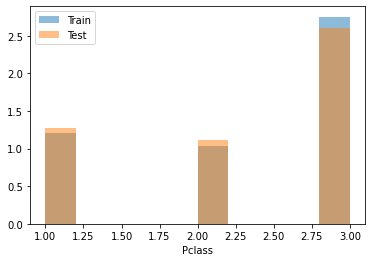

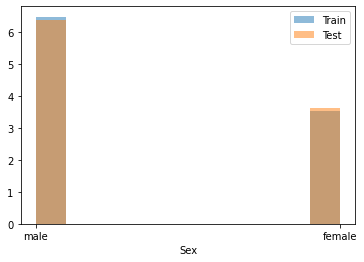

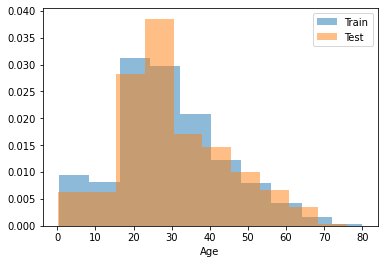

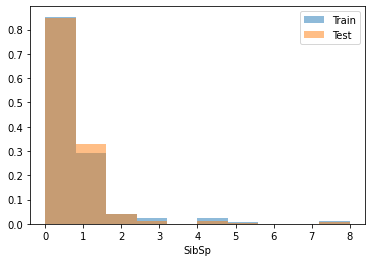

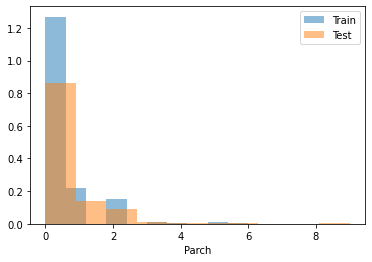

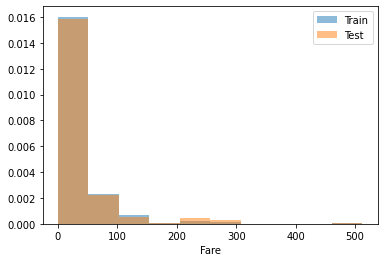

In [164]:
# Visualizing feature distributions across train/test sets to ensure they match
df_test = pd.read_csv(DIR + 'test.csv')
for f in ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']:
  if (f == 'Age') or (f == 'Fare'):
    df = df_train.loc[np.logical_not(df_train[f].isna()), :]
  else:
    df = df_train.copy()
  plt.figure()
  plt.hist(df_train[f], density=True, alpha=0.5)
  plt.hist(df_test[f], density=True, alpha=0.5)
  plt.xlabel(f)
  plt.legend(['Train', 'Test'])
  plt.show()

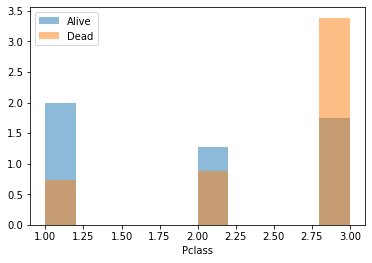

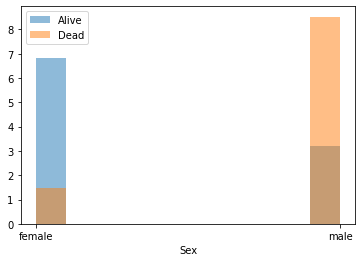

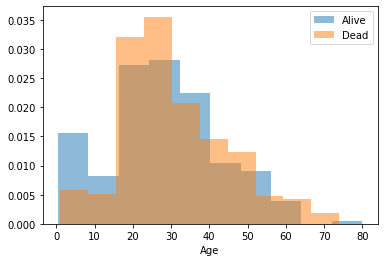

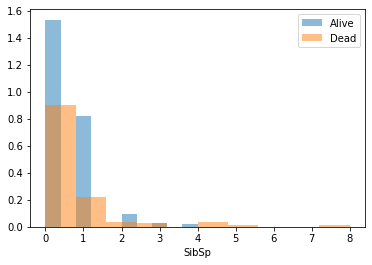

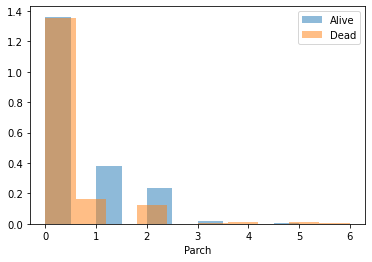

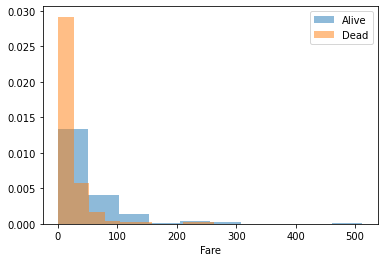

In [163]:
# Visualizing features against the feature of interest
for f in ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']:
  if f == 'Age':
    df = df_train.loc[np.logical_not(df_train['Age'].isna()), :]
  else:
    df = df_train.copy()
  plt.figure()
  plt.hist(df.loc[(df_train['Survived']==1), f], density=True, alpha=0.5)
  plt.hist(df.loc[(df_train['Survived']==0), f], density=True, alpha=0.5)
  plt.xlabel(f)
  plt.legend(['Alive', 'Dead'])
  plt.show()

  # Notes:
  # The richer, the less likely you would die
  # Men died disproportionally more than women
  # Those younger than 15 had a significantly higher chance of surviving than those older
  # The more parents you had and the less siblings, the more likely you were of surviving
  # The higher your fare, the more likely you survived

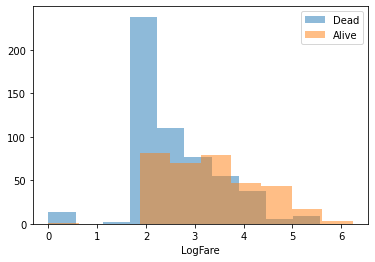

In [37]:
# Visualizing the log of the fare distribution
X_dead, X_alive = df_train.loc[df_train['Survived'] == 0, 'Fare'], df_train.loc[df_train['Survived'] == 1, 'Fare']
X_dead[X_dead < 1], X_alive[X_alive < 1] = 1, 1 # prevent numerical errors taking the log of the dist.
logfare_dead, logfare_alive = np.log(X_dead), np.log(X_alive) # make distribution appear more normal
plt.figure()
plt.hist(logfare_dead, alpha=0.5)
plt.hist(logfare_alive, alpha=0.5)
plt.xlabel('LogFare')
plt.legend(['Dead', 'Alive'])
plt.show()

### Conclusion:
- Sex and Pclass seem to be the most predictive variables
- SibSp and Parch may also be predictive
- Age may be predictive, but would require imputation of missing values
- Fares also seem predictive, but may be highly correlated with Pclass

Variables not considered:
- Name: While titles may be important, such information is likely to be correlated to Pclass and Fares
- Ticket: While the ticket may contain information relative to ship location, I chose to focus on other present variables
- Embarked: Where the passenger embarked is unlikely to reflect their chances of survival unless it reflects social class, which is already accounted for by Pclass

## 2. Model 1: Neglect Age Due To Missing Values
In this section, I will avoid imputing the missing age variables and use other predictor variables.


In [38]:
# Data Cleaning (including dummy encoding for variables)
simple = SimpleImputer(strategy='median')
df1 = df_train.drop(['Name', 'Ticket', 'Cabin', 'Embarked', 'Age', 'Parch', 'SibSp'], axis=1)
df1 = pd.get_dummies(df1, prefix=['Pclass', 'Sex'], columns=['Pclass', 'Sex'], drop_first=True)
# Take log of the fares
df1.loc[df1['Fare'] < 1, 'Fare'] = 1 # prevent numerical errors from taking the log
df1['Fare'] = np.log(df1['Fare']) # take log to make fares distribution appear more normal
# Drop outliers in the fares, and standardize values
fare_scaler = StandardScaler()
fare_scaler = fare_scaler.fit(df1[['Fare']])
df1['Fare'] = fare_scaler.transform(df1[['Fare']])
simple = simple.fit(df1.drop('PassengerId', axis=1)) # exclude ID from imputation
df1 = pd.DataFrame(data=np.c_[df1['PassengerId'],simple.transform(df1.drop('PassengerId', axis=1))], columns=df1.columns)

In [39]:
# Defining train and test sets
X, y = df1.drop(['Survived', 'PassengerId'], axis=1), df1['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0) # train-test split!

In [ ]:
# Logistic Regression sklearn gridsearch
params = {
    'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver': ['lbfgs', 'liblinear', 'newton-cholesky']
    }
reg = LogisticRegression()
clf = GridSearchCV(reg, params, scoring='accuracy', verbose=1).fit(X_train, y_train)
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score')

In [41]:
# Best parameter values according to grid search
model = LogisticRegression(C=29.7635, penalty='l1', solver='liblinear').fit(X_train, y_train)
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.82      0.83      0.82       139
         1.0       0.71      0.70      0.71        84

    accuracy                           0.78       223
   macro avg       0.77      0.76      0.77       223
weighted avg       0.78      0.78      0.78       223



In [ ]:
# Grid search outcome for SVM!
params = {
    'gamma' : [1, 0.1, 0.01, 0.001],
    'C' : [0.1, 1, 10, 100],
    'kernel': ['rbf', 'poly', 'sigmoid', 'linear']
    }
model = SVC()
clf = GridSearchCV(model, params, scoring='accuracy', verbose=1).fit(X_train, y_train)
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score')

In [43]:
# Best parameter values according to grid search
model = SVC(C=10, gamma=0.1, kernel='rbf').fit(X_train, y_train)
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.82      0.87      0.85       139
         1.0       0.76      0.69      0.72        84

    accuracy                           0.80       223
   macro avg       0.79      0.78      0.79       223
weighted avg       0.80      0.80      0.80       223



In [ ]:
# Grid Search for Decision Trees!
params = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : range(10),
    'min_samples_split': range(10),
    'min_samples_leaf': range(5)
      }
model = DecisionTreeClassifier()
clf = GridSearchCV(model, params, scoring='accuracy', verbose=1).fit(X_train, y_train)
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score')

In [45]:
# Best parameter values according to grid search
model = DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_leaf=4, min_samples_split=6).fit(X_train, y_train)
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.83      0.85      0.84       139
         1.0       0.74      0.71      0.73        84

    accuracy                           0.80       223
   macro avg       0.79      0.78      0.78       223
weighted avg       0.80      0.80      0.80       223



In [ ]:
# Grid Search for Random Forests!
params = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : range(0, 10, 2),
    'min_samples_split': range(1, 10, 2),
    'min_samples_leaf': range(5),
    'n_estimators': [10, 50, 100, 150]
      }
model = RandomForestClassifier()
clf = GridSearchCV(model, params, scoring='accuracy', verbose=1).fit(X_train, y_train)
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score')

In [47]:
# Best parameter values according to grid search
model = RandomForestClassifier(criterion='entropy', max_depth=6,
                               min_samples_leaf=1, min_samples_split=5, 
                               n_estimators=50 ).fit(X_train, y_train)
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.82      0.87      0.85       139
         1.0       0.76      0.69      0.72        84

    accuracy                           0.80       223
   macro avg       0.79      0.78      0.79       223
weighted avg       0.80      0.80      0.80       223



In [ ]:
# Grid Search for Boosted Trees!
params = {
    'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    'max_depth' : range(4, 10, 2),
    'min_samples_split': range(1, 10, 2),
    'min_samples_leaf': range(1, 10, 2),
    'n_estimators': [10, 50]
      }
model = GradientBoostingClassifier()
clf = GridSearchCV(model, params, scoring='accuracy', verbose=1).fit(X_train, y_train)
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score')

In [49]:
# Best parameter values according to grid search
model = GradientBoostingClassifier(learning_rate=0.15, max_depth=4,
                              min_samples_split=7, min_samples_leaf=1,
                               n_estimators=50).fit(X_train, y_train)
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.82      0.88      0.85       139
         1.0       0.77      0.69      0.73        84

    accuracy                           0.81       223
   macro avg       0.80      0.78      0.79       223
weighted avg       0.81      0.81      0.80       223



## 3. Model 2: Imputation For Missing Values
This section will be used to ensure imputation is taken care of, while also accounting for the Age iv. As was validated heuristically, the SimpleImputer using the median seemed to exhibit similar performance improvements to the KNNImputer, hence the former was used.

In [5]:
# Trying to do simple median imputation, and comparing results with KNNImputation
simple = SimpleImputer(strategy='median') # --> Median chosen for outlier robustness
# Data Cleaning (including dummy encoding for variables)
df1 = df_train.drop(['Name', 'Ticket', 'Cabin', 'Embarked', 'Parch', 'SibSp'], axis=1)
df1 = pd.get_dummies(df1, prefix=['Pclass', 'Sex'], columns=['Pclass', 'Sex'], drop_first=True)
# Take log of the fares
df1.loc[df1['Fare'] < 1, 'Fare'] = 1 # prevent numerical errors from taking the log
df1['Fare'] = np.log(df1['Fare']) # take log to make fares distribution appear more normal
# Standard scaling prior to imputation
scaler = StandardScaler()
scaler = scaler.fit(df1.loc[~df1['Age'].isna(), ['Fare', 'Age']])
df1[['Fare', 'Age']] = scaler.transform(df1[['Fare', 'Age']])
# Creating 2 differently imputed datasets
simple = simple.fit(df1.drop(['PassengerId', 'Survived'], axis=1)) # exclude ID from imputation
df1 = pd.DataFrame(data=np.c_[df1[['PassengerId', 'Survived']],
                              simple.transform(df1.drop(['PassengerId', 'Survived'], axis=1))],
                              columns=df1.columns)

In [ ]:
# Logistic Regression results with either imputed dataset for comparison!
df_data = df1.copy() # which imputed dataset to use (seemingly worse score with knn imputer)
X, y = df_data.drop(['Survived', 'PassengerId'], axis=1), df_data['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # train-test split!
params = {
    'penalty': ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver': ['lbfgs', 'liblinear', 'newton-cg']
    }
reg = LogisticRegression()
clf = GridSearchCV(reg, params, scoring='accuracy', verbose=1).fit(X_train, y_train)
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score')

In [52]:
# Best parameters according to grid search
model = LogisticRegression(C=0.6158, penalty='l2', solver='liblinear').fit(X_train, y_train)
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.82      0.85      0.84       110
         1.0       0.75      0.70      0.72        69

    accuracy                           0.79       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



In [ ]:
# SVM results with either imputed dataset for comparison!
df_data = df1.copy() # which imputed dataset to use (Seemingly no difference in the ending test score)
X, y = df_data.drop(['Survived', 'PassengerId'], axis=1), df_data['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # train-test split!
params = {
    'gamma' : [1, 0.1, 0.01, 0.001],
    'C' : [0.1, 1, 10, 100],
    'kernel': ['rbf', 'poly', 'sigmoid']
    }
model = SVC()
clf = GridSearchCV(model, params, scoring='accuracy', verbose=1).fit(X_train, y_train)
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score')

In [10]:
# Best parameter values according to grid search
model = SVC(C=10, gamma=1, kernel='rbf').fit(X_train, y_train)
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.80      0.89      0.84       110
         1.0       0.79      0.64      0.70        69

    accuracy                           0.79       179
   macro avg       0.79      0.76      0.77       179
weighted avg       0.79      0.79      0.79       179



In [6]:
# RandomForest results with either imputed dataset for comparison! --> Any form of imputation to include age seems to boost scores
df_data = df1.copy() # which imputed dataset to use (Seemingly no difference in the ending test score)
X, y = df_data.drop(['Survived', 'PassengerId'], axis=1), df_data['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # train-test split!
params = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : range(2, 20, 1),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 10),
    'n_estimators': [90, 100, 115, 130]
      }
model = RandomForestClassifier()
clf = GridSearchCV(model, params, scoring='accuracy', verbose=1).fit(X_train, y_train)
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score')

In [7]:
# Best parameter values according to grid search
model = RandomForestClassifier(
    criterion='gini',
    max_depth=8,
    min_samples_leaf=1,
    min_samples_split=6,	
    n_estimators=115
).fit(X_train, y_train)
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.83      0.95      0.88       110
         1.0       0.89      0.68      0.77        69

    accuracy                           0.84       179
   macro avg       0.86      0.81      0.83       179
weighted avg       0.85      0.84      0.84       179



## Deep Learning: A Vanilla NN Approach
In this section, I will attempt to build a robust vanilla neural network with Keras to predit the output of whether someone survived or died. Since the median imputer did not seem to affect performance relative to the KNN imputer, I will continue using the median imputer for this section.

In [122]:
# Trying to do simple median imputation, and comparing results with KNNImputation
simple = SimpleImputer(strategy='median') # --> Median chosen for outlier robustness
# Data Cleaning (including dummy encoding for variables)
df1 = df_train.drop(['Name', 'Ticket', 'Cabin', 'Embarked', 'Parch', 'SibSp'], axis=1)
df1 = pd.get_dummies(df1, prefix=['Pclass', 'Sex'], columns=['Pclass', 'Sex'], drop_first=True)
# Take log of the fares
df1.loc[df1['Fare'] < 1, 'Fare'] = 1 # prevent numerical errors from taking the log
df1['Fare'] = np.log(df1['Fare']) # take log to make fares distribution appear more normal
# Standard scaling prior to imputation
scaler = StandardScaler()
scaler = scaler.fit(df1.loc[~df1['Age'].isna(), ['Fare', 'Age']])
df1[['Fare', 'Age']] = scaler.transform(df1[['Fare', 'Age']])
# Creating 2 differently imputed datasets
simple = simple.fit(df1.drop(['PassengerId', 'Survived'], axis=1)) # exclude ID from imputation
df1 = pd.DataFrame(data=np.c_[df1[['PassengerId', 'Survived']],
                              simple.transform(df1.drop(['PassengerId', 'Survived'], axis=1))],
                              columns=df1.columns)

In [136]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Train test split
X, y = df1.drop(['Survived', 'PassengerId'], axis=1), df1['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # train-test split!
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0) # train-val split!

# Initialize model architecture
model = keras.Sequential()
model.add(layers.Dense(10, input_shape=(5,)))
# model.add(layers.Dropout(0.1))
model.add(layers.Activation('relu'))
model.add(layers.Dense(7))
# model.add(layers.Dropout(0.1))
model.add(layers.Activation('relu'))
model.add(layers.Dense(5))
# model.add(layers.Dropout(0.1))
model.add(layers.Activation('relu'))
model.add(layers.Dense(3))
model.add(layers.Activation('relu'))
model.add(layers.Dense(1, activation='sigmoid')) # since binary classification

# Set optimizer and compile
opt = opt = keras.optimizers.Adam(learning_rate=3e-3)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# Training
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=16)

Epoch 1/100
36/36 [==============================] - 2s 21ms/step - loss: 0.6793 - accuracy: 0.6257 - val_loss: 0.6706 - val_accuracy: 0.5944
Epoch 2/100
36/36 [==============================] - 0s 7ms/step - loss: 0.6168 - accuracy: 0.7469 - val_loss: 0.6056 - val_accuracy: 0.6993
Epoch 3/100
36/36 [==============================] - 0s 5ms/step - loss: 0.5115 - accuracy: 0.7803 - val_loss: 0.5624 - val_accuracy: 0.6783
Epoch 4/100
36/36 [==============================] - 0s 3ms/step - loss: 0.4548 - accuracy: 0.8014 - val_loss: 0.5528 - val_accuracy: 0.7413
Epoch 5/100
36/36 [==============================] - 0s 2ms/step - loss: 0.4221 - accuracy: 0.8278 - val_loss: 0.5501 - val_accuracy: 0.7552
Epoch 6/100
36/36 [==============================] - 0s 3ms/step - loss: 0.4117 - accuracy: 0.8207 - val_loss: 0.5484 - val_accuracy: 0.7552
Epoch 7/100
36/36 [==============================] - 0s 2ms/step - loss: 0.4041 - accuracy: 0.8295 - val_loss: 0.5621 - val_accuracy: 0.7692
Epoch 8/100


In [137]:
# Evaluating performance of model on an unseen test set
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.3875597417354584
Test accuracy: 0.8212290406227112


In [138]:
# Double checking that I'm doing things right
pred = (model.predict(X_test) > 0.5).astype(np.int32)
print('Accuracy: {}'.format(np.mean((pred.flatten()==y_test).astype(int))))

6/6 [==============================] - 0s 3ms/step
Accuracy: 0.8212290502793296


# Submission!
Below I have run my best performing model on the test set and submitted the output. Wish me luck!

In [8]:
# Loading in the data
df_test = pd.read_csv(DIR + 'test.csv')
# Data Cleaning (including dummy encoding for variables)
df1 = df_test.drop(['Name', 'Ticket', 'Cabin', 'Embarked', 'Parch', 'SibSp'], axis=1)
df1 = pd.get_dummies(df1, prefix=['Pclass', 'Sex'], columns=['Pclass', 'Sex'], drop_first=True)
# Take log of the fares
df1.loc[df1['Fare'] < 1, 'Fare'] = 1 # prevent numerical errors from taking the log
df1['Fare'] = np.log(df1['Fare']) # take log to make fares distribution appear more normal
# Standard scaling prior to imputation (with previously trained scaler)
df1[['Fare', 'Age']] = scaler.transform(df1[['Fare', 'Age']])
# Imputing missing values with previously fitted imputer
df1 = pd.DataFrame(data=np.c_[df1['PassengerId'],
                              simple.transform(df1.drop('PassengerId', axis=1))],
                    columns=df1.columns)

In [9]:
df1['PassengerId'] = df1['PassengerId'].astype(np.int32)

In [11]:
# Obtaining model predictions :)
y_test = (model.predict(df1.drop('PassengerId', axis=1)).astype(np.int32))
submission = df1[['PassengerId']]
submission['Survived'] = y_test
submission.to_csv('submission.csv', index=False)

<ipython-input-11-719a79e9b9f3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['Survived'] = y_test


In [121]:
# Deep learning submission
y_test = (model.predict(df1.drop('PassengerId', axis=1)) > 0.5).astype(np.int32)
submission = df1[['PassengerId']]
submission['Survived'] = y_test
submission.to_csv('submission.csv', index=False)

14/14 [==============================] - 0s 1ms/step


<ipython-input-121-1f14d5c86b92>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['Survived'] = y_test


In [29]:
y_test.dtype

dtype('float64')